In [1]:
import os
from tqdm import tqdm
from sys import getsizeof
from timeit import default_timer as timer

os.environ["OMP_NUM_THREADS"] = "1"  # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "1"  # export OPENBLAS_NUM_THREADS=4
os.environ["MKL_NUM_THREADS"] = "1"  # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"  # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "1"  # export NUMEXPR_NUM_THREADS=6

import numpy as np
import sisl
from src.grogu_magn.useful import *
from mpi4py import MPI
import pickle
from numpy.linalg import inv
import warnings

# runtime information
times = dict()
times["start_time"] = timer()
########################
# it works if data is in downloads folder
########################
sisl.__version__

[Mac:27855] shmem: mmap: an error occurred while determining whether or not /var/folders/yh/dx7xl94n3g52ts3td8qcxjcc0000gn/T//ompi.Mac.501/jf.0/204800000/sm_segment.Mac.501.c350000.0 could be created.


'0.14.3'

In [2]:
# this cell mimicks an input file
fdf = sisl.get_sile(
    "/Users/danielpozsar/Downloads/nojij/Fe3GeTe2/monolayer/soc/lat3_791/Fe3GeTe2.fdf"
)  # ./Jij_for_Marci_6p45ang/CrBr.fdf

outfile = "test"
if not outfile.endswith(".pickle"):
    outfile += ".pickle"
# this information needs to be given at the input!!
scf_xcf_orientation = np.array([0, 0, 1])  # z
# list of reference directions for around which we calculate the derivatives
# o is the quantization axis, v and w are two axes perpendicular to it
# at this moment the user has to supply o,v,w on the input.
# we can have some default for this
ref_xcf_orientations = [
    dict(o=np.array([1, 0, 0]), vw=[np.array([0, 1, 0]), np.array([0, 0, 1])]),
    dict(o=np.array([0, 1, 0]), vw=[np.array([1, 0, 0]), np.array([0, 0, 1])]),
    dict(o=np.array([0, 0, 1]), vw=[np.array([1, 0, 0]), np.array([0, 1, 0])]),
]


# human readable definition of magnetic entities ./lat3_791/Fe3GeTe2.fdf
magnetic_entities = [
    dict(atom=3, l=2),
    dict(atom=4, l=2),
    dict(atom=5, l=2),
]
# pair information ./lat3_791/Fe3GeTe2.fdf
pairs = [
    # isotropic should be -82 meV
    dict(ai=0, aj=1, Ruc=np.array([0, 0, 0])),
    dict(ai=1, aj=2, Ruc=np.array([0, 0, 0])),
    dict(ai=0, aj=2, Ruc=np.array([0, 0, 0])),
]

"""
# human readable definition of magnetic entities ./Jij_for_Marci_6p45ang/CrBr.fdf
magnetic_entities = [
    dict(atom=0, l=2),
    dict(atom=1, l=2),
    dict(atom=2, l=2),
]
# pair information ./Jij_for_Marci_6p45ang/CrBr.fdf
pairs = [
    dict(ai=0, aj=1, Ruc=np.array([0, 0, 0])),
    dict(ai=0, aj=2, Ruc=np.array([0, 0, 0])),
    dict(ai=1, aj=2, Ruc=np.array([0, 0, 0])),
    dict(ai=0, aj=1, Ruc=np.array([1, 0, 0])),
    dict(ai=0, aj=2, Ruc=np.array([1, 0, 0])),
    dict(ai=0, aj=1, Ruc=np.array([-1, 0, 0])),
    dict(ai=0, aj=2, Ruc=np.array([-1, 0, 0])),
    dict(ai=0, aj=1, Ruc=np.array([0, 1, 0])),
    dict(ai=0, aj=2, Ruc=np.array([0, 1, 0])),
    dict(ai=0, aj=1, Ruc=np.array([0, 1, 0])),
    dict(ai=0, aj=2, Ruc=np.array([0, 1, 0])),
]
"""

# Brilloun zone sampling and Green function contour integral
kset = 20
kdirs = "xy"
ebot = -13
eset = 100
esetp = 100


# MPI parameters
comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()
root_node = 0

simulation_parameters = dict(
    path="Not yet specified.",
    outpath=outfile,
    scf_xcf_orientation=scf_xcf_orientation,
    ref_xcf_orientations=ref_xcf_orientations,
    kset=kset,
    kdirs=kdirs,
    ebot=ebot,
    eset=eset,
    esetp=esetp,
    parallel_size=size,
)

# digestion of the input
# read in hamiltonian
dh = fdf.read_hamiltonian()
simulation_parameters["cell"] = fdf.read_geometry().cell

# unit cell index
uc_in_sc_idx = dh.lattice.sc_index([0, 0, 0])

if rank == root_node:
    print_parameters(simulation_parameters)
    times["setup_time"] = timer()
    print(f"Setup done. Elapsed time: {times['setup_time']} s")
    print(
        "================================================================================================================================================================"
    )

Input file: 
Not yet specified.
Output file: 
test.pickle
Number of nodes in the parallel cluster:  1
Cell [Ang]: 
[[ 3.79100000e+00  0.00000000e+00  0.00000000e+00]
 [-1.89550000e+00  3.28310231e+00  0.00000000e+00]
 [ 1.25954923e-15  2.18160327e-15  2.05700000e+01]]
DFT axis: 
[0 0 1]
Quantization axis and perpendicular rotation directions:
[1 0 0]  --»  [array([0, 1, 0]), array([0, 0, 1])]
[0 1 0]  --»  [array([1, 0, 0]), array([0, 0, 1])]
[0 0 1]  --»  [array([1, 0, 0]), array([0, 1, 0])]
Parameters for the contour integral:
Number of k points:  20
k point directions:  xy
Ebot:  -13
Eset:  100
Esetp:  100
Setup done. Elapsed time: 1.811041458 s


/Users/danielpozsar/Documents/oktatás/elte/phd/grogu_project/.venv/lib/python3.9/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/danielpozsar/Documents/oktatás/elte/phd/grogu_project/.venv/lib/python3.9/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


-12.806739
-0.01254111
xyz[-3:]: red, green, blue


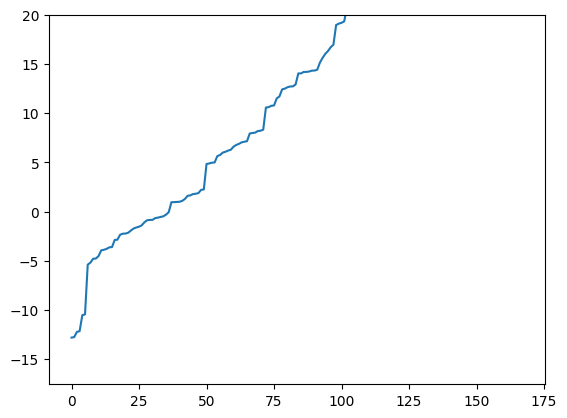

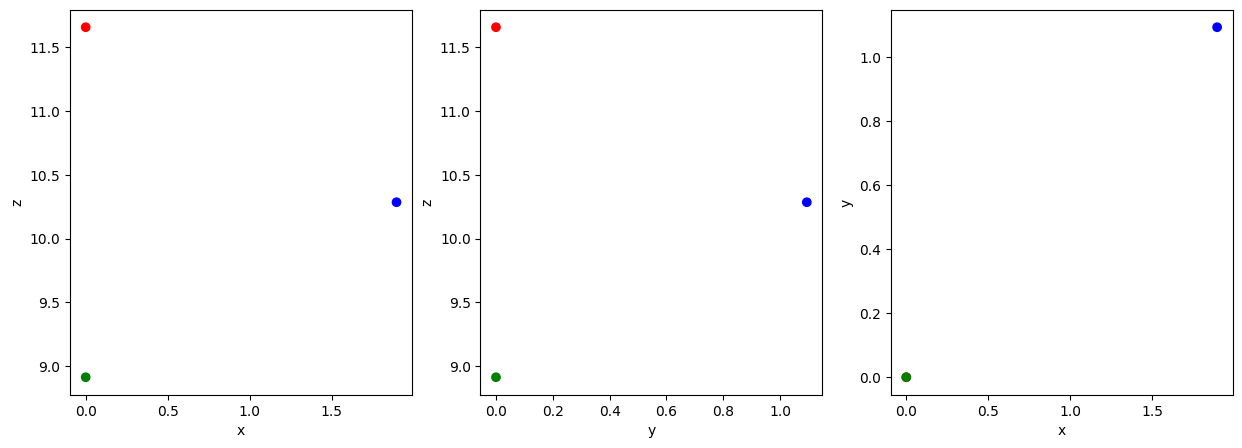

In [3]:
import matplotlib.pyplot as plt

plt.plot(np.sort(dh.eig()))
plt.ylim(None, 20)
print(np.real(dh.eig()).min())
print(np.imag(dh.eig()).min())

import matplotlib.pyplot as plt

coords = dh.xyz[-3:]


plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.scatter(coords[:, 0], coords[:, 2], color=["r", "g", "b"])
plt.xlabel("x")
plt.ylabel("z")
plt.subplot(132)
plt.scatter(coords[:, 1], coords[:, 2], color=["r", "g", "b"])
plt.xlabel("y")
plt.ylabel("z")
plt.subplot(133)
plt.scatter(coords[:, 0], coords[:, 1], color=["r", "g", "b"])
plt.xlabel("x")
plt.ylabel("y")
print("xyz[-3:]: red, green, blue")

In [4]:
NO = dh.no  # shorthand for number of orbitals in the unit cell

# preprocessing Hamiltonian and overlap matrix elements
h11 = dh.tocsr(dh.M11r)
h11 += dh.tocsr(dh.M11i) * 1.0j
h11 = h11.toarray().reshape(NO, dh.n_s, NO).transpose(0, 2, 1).astype("complex128")

h22 = dh.tocsr(dh.M22r)
h22 += dh.tocsr(dh.M22i) * 1.0j
h22 = h22.toarray().reshape(NO, dh.n_s, NO).transpose(0, 2, 1).astype("complex128")

h12 = dh.tocsr(dh.M12r)
h12 += dh.tocsr(dh.M12i) * 1.0j
h12 = h12.toarray().reshape(NO, dh.n_s, NO).transpose(0, 2, 1).astype("complex128")

h21 = dh.tocsr(dh.M21r)
h21 += dh.tocsr(dh.M21i) * 1.0j
h21 = h21.toarray().reshape(NO, dh.n_s, NO).transpose(0, 2, 1).astype("complex128")

sov = (
    dh.tocsr(dh.S_idx)
    .toarray()
    .reshape(NO, dh.n_s, NO)
    .transpose(0, 2, 1)
    .astype("complex128")
)


# Reorganization of Hamiltonian and overlap matrix elements to SPIN BOX representation
U = np.vstack(
    [np.kron(np.eye(NO, dtype=int), [1, 0]), np.kron(np.eye(NO, dtype=int), [0, 1])]
)
# This is the permutation that transforms ud1ud2 to u12d12
# That is this transforms FROM SPIN BOX to ORBITAL BOX => U
# the inverse transformation is U.T u12d12 to ud1ud2
# That is FROM ORBITAL BOX to SPIN BOX => U.T

# From now on everything is in SPIN BOX!!
hh, ss = np.array(
    [
        U.T @ np.block([[h11[:, :, i], h12[:, :, i]], [h21[:, :, i], h22[:, :, i]]]) @ U
        for i in range(dh.lattice.nsc.prod())
    ]
), np.array(
    [
        U.T
        @ np.block([[sov[:, :, i], sov[:, :, i] * 0], [sov[:, :, i] * 0, sov[:, :, i]]])
        @ U
        for i in range(dh.lattice.nsc.prod())
    ]
)


# symmetrizing Hamiltonian and overlap matrix to make them hermitian
for i in range(dh.lattice.sc_off.shape[0]):
    j = dh.lattice.sc_index(-dh.lattice.sc_off[i])
    h1, h1d = hh[i], hh[j]
    hh[i], hh[j] = (h1 + h1d.T.conj()) / 2, (h1d + h1.T.conj()) / 2
    s1, s1d = ss[i], ss[j]
    ss[i], ss[j] = (s1 + s1d.T.conj()) / 2, (s1d + s1.T.conj()) / 2

# identifying TRS and TRB parts of the Hamiltonian
TAUY = np.kron(np.eye(NO), tau_y)
hTR = np.array([TAUY @ hh[i].conj() @ TAUY for i in range(dh.lattice.nsc.prod())])
hTRS = (hh + hTR) / 2
hTRB = (hh - hTR) / 2

# extracting the exchange field
traced = [spin_tracer(hTRB[i]) for i in range(dh.lattice.nsc.prod())]  # equation 77
XCF = np.array(
    [
        np.array([f["x"] for f in traced]),
        np.array([f["y"] for f in traced]),
        np.array([f["z"] for f in traced]),
    ]
)  # equation 77

# Check if exchange field has scalar part
max_xcfs = abs(np.array(np.array([f["c"] for f in traced]))).max()
if max_xcfs > 1e-12:
    warnings.warn(
        f"Exchange field has non negligible scalar part. Largest value is {max_xcfs}"
    )

if rank == root_node:
    times["H_and_XCF_time"] = timer()
    print(
        f"Hamiltonian and exchange field rotated. Elapsed time: {times['H_and_XCF_time']} s"
    )
    print(
        "================================================================================================================================================================"
    )

Hamiltonian and exchange field rotated. Elapsed time: 2.613376875 s


In [5]:
# for every site we have to store 3 Greens function (and the associated _tmp-s) in the 3 reference directions
for i, mag_ent in enumerate(magnetic_entities):
    parsed = parse_magnetic_entity(dh, **mag_ent)  # parse orbital indexes
    magnetic_entities[i]["orbital_indeces"] = parsed
    # calculate spin box indexes
    magnetic_entities[i]["spin_box_indeces"] = blow_up_orbindx(parsed)
    # if orbital is not set use all
    if "l" not in mag_ent.keys():
        mag_ent["l"] = "all"
    if isinstance(mag_ent["atom"], int):
        mag_ent["tags"] = [
            f"[{mag_ent['atom']}]{dh.atoms[mag_ent['atom']].tag}({mag_ent['l']})"
        ]
        mag_ent["xyz"] = [dh.xyz[mag_ent["atom"]]]
    if isinstance(mag_ent["atom"], list):
        mag_ent["tags"] = []
        mag_ent["xyz"] = []
        # iterate over atoms
        for atom_idx in mag_ent["atom"]:
            mag_ent["tags"].append(
                f"[{atom_idx}]{dh.atoms[atom_idx].tag}({mag_ent['l']})"
            )
            mag_ent["xyz"].append(dh.xyz[atom_idx])

    # calculate size for Greens function generation
    spin_box_shape = len(mag_ent["spin_box_indeces"])

    mag_ent["energies"] = []  # we will store the second order energy derivations here

    mag_ent["Gii"] = []  # Greens function
    mag_ent["Gii_tmp"] = []  # Greens function for parallelization
    # These will be the perturbed potentials from eq. 100
    mag_ent["Vu1"] = [list([]) for _ in range(len(ref_xcf_orientations))]
    mag_ent["Vu2"] = [list([]) for _ in range(len(ref_xcf_orientations))]
    for i in ref_xcf_orientations:
        # Greens functions for every quantization axis
        mag_ent["Gii"].append(
            np.zeros((eset, spin_box_shape, spin_box_shape), dtype="complex128")
        )
        mag_ent["Gii_tmp"].append(
            np.zeros((eset, spin_box_shape, spin_box_shape), dtype="complex128")
        )

# for every site we have to store 2x3 Greens function (and the associated _tmp-s)
# in the 3 reference directions, because G_ij and G_ji are both needed
for pair in pairs:
    # calculate size for Greens function generation
    spin_box_shape_i = len(magnetic_entities[pair["ai"]]["spin_box_indeces"])
    spin_box_shape_j = len(magnetic_entities[pair["aj"]]["spin_box_indeces"])
    pair["tags"] = []
    for mag_ent in [magnetic_entities[pair["ai"]], magnetic_entities[pair["aj"]]]:
        tag = ""
        # get atoms of magnetic entity
        atoms_idx = mag_ent["atom"]
        orbitals = mag_ent["l"]

        # if magnetic entity contains one atoms
        if isinstance(atoms_idx, int):
            tag += f"[{atoms_idx}]{dh.atoms[atoms_idx].tag}({orbitals})"

        # if magnetic entity contains more than one atoms
        if isinstance(atoms_idx, list):
            # iterate over atoms
            atom_group = "{"
            for atom_idx in atoms_idx:
                atom_group += f"[{atom_idx}]{dh.atoms[atom_idx].tag}({orbitals})--"
            # end {} of the atoms in the magnetic entity
            tag += atom_group[:-2] + "}"
        pair["tags"].append(tag)
    pair["energies"] = []  # we will store the second order energy derivations here

    pair["Gij"] = []  # Greens function
    pair["Gji"] = []
    pair["Gij_tmp"] = []  # Greens function for parallelization
    pair["Gji_tmp"] = []
    for i in ref_xcf_orientations:
        # Greens functions for every quantization axis
        pair["Gij"].append(
            np.zeros((eset, spin_box_shape_i, spin_box_shape_j), dtype="complex128")
        )
        pair["Gij_tmp"].append(
            np.zeros((eset, spin_box_shape_i, spin_box_shape_j), dtype="complex128")
        )
        pair["Gji"].append(
            np.zeros((eset, spin_box_shape_j, spin_box_shape_i), dtype="complex128")
        )
        pair["Gji_tmp"].append(
            np.zeros((eset, spin_box_shape_j, spin_box_shape_i), dtype="complex128")
        )

if rank == root_node:
    times["site_and_pair_dictionaries_time"] = timer()
    print(
        f"Site and pair dictionaries created. Elapsed time: {times['site_and_pair_dictionaries_time']} s"
    )
    print(
        "================================================================================================================================================================"
    )

Site and pair dictionaries created. Elapsed time: 2.628747208 s


In [6]:
kset = make_kset(dirs=kdirs, NUMK=kset)  # generate k space sampling
wkset = np.ones(len(kset)) / len(kset)  # generate weights for k points
kpcs = np.array_split(kset, size)  # split the k points based on MPI size
kpcs[root_node] = tqdm(kpcs[root_node], desc="k loop")

if rank == root_node:
    times["k_set_time"] = timer()
    print(f"k set created. Elapsed time: {times['k_set_time']} s")
    print(
        "================================================================================================================================================================"
    )

k loop:   0%|          | 0/400 [00:00<?, ?it/s]

k set created. Elapsed time: 2.648811208 s


In [7]:
# this will contain the three hamiltonians in the reference directions needed to calculate the energy variations upon rotation
hamiltonians = []

# iterate over the reference directions (quantization axes)
for i, orient in enumerate(ref_xcf_orientations):
    # obtain rotated exchange field
    R = RotMa2b(scf_xcf_orientation, orient["o"])
    rot_XCF = np.einsum("ij,jklm->iklm", R, XCF)
    rot_H_XCF = sum(
        [np.kron(rot_XCF[i], tau) for i, tau in enumerate([tau_x, tau_y, tau_z])]
    )
    rot_H_XCF_uc = rot_H_XCF[uc_in_sc_idx]

    # obtain total Hamiltonian with the rotated exchange field
    rot_H = (
        hTRS + rot_H_XCF
    )  # equation 76 #######################################################################################

    hamiltonians.append(
        dict(orient=orient["o"], H=rot_H)
    )  # store orientation and rotated Hamiltonian

    # these are the rotations (for now) perpendicular to the quantization axis
    for u in orient["vw"]:
        Tu = np.kron(np.eye(NO, dtype=int), tau_u(u))  # section 2.H

        Vu1 = 1j / 2 * commutator(rot_H_XCF_uc, Tu)  # equation 100
        Vu2 = 1 / 8 * commutator(commutator(Tu, rot_H_XCF_uc), Tu)  # equation 100

        for mag_ent in magnetic_entities:
            # fill up the perturbed potentials (for now) based on the on-site projections
            mag_ent["Vu1"][i].append(
                Vu1[:, mag_ent["spin_box_indeces"]][mag_ent["spin_box_indeces"], :]
            )
            mag_ent["Vu2"][i].append(
                Vu2[:, mag_ent["spin_box_indeces"]][mag_ent["spin_box_indeces"], :]
            )

if rank == root_node:
    times["reference_rotations_time"] = timer()
    print(
        f"Rotations done perpendicular to quantization axis. Elapsed time: {times['reference_rotations_time']} s"
    )
    print(
        "================================================================================================================================================================"
    )

Rotations done perpendicular to quantization axis. Elapsed time: 2.901047458 s


In [8]:
if rank == root_node:
    print("Starting matrix inversions")
    print(f"Total number of k points: {kset.shape[0]}")
    print(f"Number of energy samples per k point: {eset}")
    print(f"Total number of directions: {len(hamiltonians)}")
    print(
        f"Total number of matrix inversions: {kset.shape[0] * len(hamiltonians) * eset}"
    )
    print(f"The shape of the Hamiltonian and the Greens function is {NO}x{NO}={NO*NO}")
    # https://stackoverflow.com/questions/70746660/how-to-predict-memory-requirement-for-np-linalg-inv
    # memory is O(64 n**2) for complex matrices
    memory_size = getsizeof(hamiltonians[0]["H"].base) / 1024
    print(
        f"Memory taken by a single Hamiltonian is: {getsizeof(hamiltonians[0]['H'].base) / 1024} KB"
    )
    print(f"Expected memory usage per matrix inversion: {memory_size * 32} KB")
    print(
        f"Expected memory usage per k point for parallel inversion: {memory_size * len(hamiltonians) * eset * 32} KB"
    )
    print(
        f"Expected memory usage on root node: {len(np.array_split(kset, size)[0]) * memory_size * len(hamiltonians) * eset * 32 / 1024} MB"
    )
    print(
        "================================================================================================================================================================"
    )

comm.Barrier()
# ----------------------------------------------------------------------

# make energy contour
# we are working in eV now  !
# and sisil shifts E_F to 0 !
cont = make_contour(emin=ebot, enum=eset, p=esetp)
eran = cont.ze

# ----------------------------------------------------------------------
# sampling the integrand on the contour and the BZ
for k in kpcs[rank]:
    wk = wkset[rank]  # weight of k point in BZ integral
    # iterate over reference directions
    for i, hamiltonian_orientation in enumerate(hamiltonians):
        # calculate Greens function
        H = hamiltonian_orientation["H"]
        HK, SK = hsk(H, ss, dh.sc_off, k)
        # Gk = inv(SK * eran.reshape(eset, 1, 1) - HK)

        # solve Greens function sequentially for the energies, because of memory bound
        Gk = np.zeros(shape=(eset, HK.shape[0], HK.shape[1]), dtype="complex128")
        for j in range(eset):
            Gk[j] = inv(SK * eran[j] - HK)

        # store the Greens function slice of the magnetic entities (for now) based on the on-site projections
        for mag_ent in magnetic_entities:
            mag_ent["Gii_tmp"][i] += (
                Gk[:, mag_ent["spin_box_indeces"]][..., mag_ent["spin_box_indeces"]]
                * wk
            )

        for pair in pairs:
            # add phase shift based on the cell difference
            phase = np.exp(1j * 2 * np.pi * k @ pair["Ruc"].T)

            # get the pair orbital sizes from the magnetic entities
            ai = magnetic_entities[pair["ai"]]["spin_box_indeces"]
            aj = magnetic_entities[pair["aj"]]["spin_box_indeces"]

            # store the Greens function slice of the magnetic entities (for now) based on the on-site projections
            pair["Gij_tmp"][i] += Gk[:, ai][..., aj] * phase * wk
            pair["Gji_tmp"][i] += Gk[:, aj][..., ai] * phase * wk

# summ reduce partial results of mpi nodes
for i in range(len(hamiltonians)):
    for mag_ent in magnetic_entities:
        comm.Reduce(mag_ent["Gii_tmp"][i], mag_ent["Gii"][i], root=root_node)

    for pair in pairs:
        comm.Reduce(pair["Gij_tmp"][i], pair["Gij"][i], root=root_node)
        comm.Reduce(pair["Gji_tmp"][i], pair["Gji"][i], root=root_node)

if rank == root_node:
    times["green_function_inversion_time"] = timer()
    print(
        f"Calculated Greens functions. Elapsed time: {times['green_function_inversion_time']} s"
    )
    print(
        "================================================================================================================================================================"
    )

Starting matrix inversions
Total number of k points: 400
Number of energy samples per k point: 100
Total number of directions: 3
Total number of matrix inversions: 120000
The shape of the Hamiltonian and the Greens function is 84x84=7056
Memory taken by a single Hamiltonian is: 0.015625 KB
Expected memory usage per matrix inversion: 0.5 KB
Expected memory usage per k point for parallel inversion: 150.0 KB
Expected memory usage on root node: 58.59375 MB


k loop: 100%|██████████| 400/400 [03:18<00:00,  2.01it/s]

Calculated Greens functions. Elapsed time: 201.17534975 s


In [9]:
if rank == root_node:
    # iterate over the magnetic entities
    for tracker, mag_ent in enumerate(magnetic_entities):
        # iterate over the quantization axes
        for i, Gii in enumerate(mag_ent["Gii"]):
            storage = []
            # iterate over the first and second order local perturbations
            for Vu1, Vu2 in zip(mag_ent["Vu1"][i], mag_ent["Vu2"][i]):
                # The Szunyogh-Lichtenstein formula
                traced = np.trace((Vu2 @ Gii + 0.5 * Gii @ Vu1 @ Gii), axis1=1, axis2=2)
                # evaluation of the contour integral
                storage.append(np.trapz(-1 / np.pi * np.imag(traced * cont.we)))

            # fill up the magnetic entities dictionary with the energies
            magnetic_entities[tracker]["energies"].append(storage)

    print("Magnetic entities integrated.")

    # iterate over the pairs
    for tracker, pair in enumerate(pairs):
        # iterate over the quantization axes
        for i, (Gij, Gji) in enumerate(zip(pair["Gij"], pair["Gji"])):
            site_i = magnetic_entities[pair["ai"]]
            site_j = magnetic_entities[pair["aj"]]

            storage = []
            # iterate over the first order local perturbations in all possible orientations for the two sites
            for Vui in site_i["Vu1"][i]:
                for Vuj in site_j["Vu1"][i]:
                    # The Szunyogh-Lichtenstein formula
                    traced = np.trace((Vui @ Gij @ Vuj @ Gji), axis1=1, axis2=2)
                    # evaluation of the contour integral
                    storage.append(np.trapz(-1 / np.pi * np.imag(traced * cont.we)))
            # fill up the pairs dictionary with the energies
            pairs[tracker]["energies"].append(storage)

    print("Pairs integrated.")

    # calculate magnetic parameters
    for pair in pairs:
        J_iso, J_S, D = calculate_exchange_tensor(pair)
        pair["J_iso"] = J_iso * sisl.unit_convert("eV", "meV")
        pair["J_S"] = J_S * sisl.unit_convert("eV", "meV")
        pair["D"] = D * sisl.unit_convert("eV", "meV")

    print("Magnetic parameters calculated.")

    times["end_time"] = timer()
    print(
        "##################################################################### GROGU OUTPUT #############################################################################"
    )

    print_parameters(simulation_parameters)
    print_atoms_and_pairs(magnetic_entities, pairs)
    print_runtime_information(times)

    # remove clutter from magnetic entities and pair information
    for pair in pairs:
        del pair["Gij"]
        del pair["Gij_tmp"]
        del pair["Gji"]
        del pair["Gji_tmp"]
    for mag_ent in magnetic_entities:
        del mag_ent["Gii"]
        del mag_ent["Gii_tmp"]
        del mag_ent["Vu1"]
        del mag_ent["Vu2"]
    # create output dictionary with all the relevant data
    results = dict(
        parameters=simulation_parameters,
        magnetic_entities=magnetic_entities,
        pairs=pairs,
        runtime=times,
    )
    # save dictionary
    with open(outfile, "wb") as output_file:
        pickle.dump(results, output_file)

Magnetic entities integrated.
Pairs integrated.
Magnetic parameters calculated.
##################################################################### GROGU OUTPUT #############################################################################
Input file: 
Not yet specified.
Output file: 
test.pickle
Number of nodes in the parallel cluster:  1
Cell [Ang]: 
[[ 3.79100000e+00  0.00000000e+00  0.00000000e+00]
 [-1.89550000e+00  3.28310231e+00  0.00000000e+00]
 [ 1.25954923e-15  2.18160327e-15  2.05700000e+01]]
DFT axis: 
[0 0 1]
Quantization axis and perpendicular rotation directions:
[1 0 0]  --»  [array([0, 1, 0]), array([0, 0, 1])]
[0 1 0]  --»  [array([1, 0, 0]), array([0, 0, 1])]
[0 0 1]  --»  [array([1, 0, 0]), array([0, 1, 0])]
Parameters for the contour integral:
Number of k points:  20
k point directions:  xy
Ebot:  -13
Eset:  100
Esetp:  100
Atomic information: 
-------------------------------------------------------------------------------------------------------------------------

In [10]:
##################################################################### GROGU OUTPUT #############################################################################
================================================================================================================================================================
Input file: 
Not yet specified.
Output file: 
test.pickle
Number of nodes in the parallel cluster:  1
================================================================================================================================================================
Cell [Ang]: 
[[ 3.79100000e+00  0.00000000e+00  0.00000000e+00]
 [-1.89550000e+00  3.28310231e+00  0.00000000e+00]
 [ 1.25954923e-15  2.18160327e-15  2.05700000e+01]]
================================================================================================================================================================
DFT axis: 
[0 0 1]
Quantization axis and perpendicular rotation directions:
[1 0 0]  --»  [array([0, 1, 0]), array([0, 0, 1])]
[0 1 0]  --»  [array([1, 0, 0]), array([0, 0, 1])]
[0 0 1]  --»  [array([1, 0, 0]), array([0, 1, 0])]
================================================================================================================================================================
Parameters for the contour integral:
Number of k points:  20
k point directions:  xy
Ebot:  -15
Eset:  100
Esetp:  1000
================================================================================================================================================================
Atomic information: 
----------------------------------------------------------------------------------------------------------------------------------------------------------------
[atom index]Element(orbitals)        x [Ang]        y [Ang]        z [Ang]        Sx        Sy        Sz        Q        Lx        Ly        Lz        Jx        Jy        Jz
----------------------------------------------------------------------------------------------------------------------------------------------------------------
[3]Fe(2)        -7.339158738013707e-06        4.149278510690423e-06        11.657585837928032

[4]Fe(2)        -7.326987662162937e-06        4.158274523275774e-06        8.912422537596708

[5]Fe(2)        1.8954667088117545        1.0943913231921656        10.285002698393109

================================================================================================================================================================
Exchange [meV]
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Magnetic entity1        Magnetic entity2       [i  j  k]       d [Ang]
----------------------------------------------------------------------------------------------------------------------------------------------------------------
[3]Fe(2)        [4]Fe(2)        [0 0 0]        d [Ang] Not yet.
Isotropic:  -63.51146633376187
DMI:  [-9.32966002e-01 -8.89800564e-04 -2.02862680e-06]
Symmetric-anisotropy:  [-3.33721683e+00  1.29672703e+00  6.03687008e-04 -8.09695186e-04
 -6.00702131e-06]
Energies for debugging: 
array([[-6.22147393e-02, -9.32959995e-04,  9.32972009e-04,
        -6.14709765e-02],
       [-6.75755955e-02,  8.09695186e-07, -9.69905943e-07,
        -6.68486832e-02],
       [-5.36624493e-02, -6.05715634e-07, -6.01658381e-07,
        -5.36632256e-02]])
J_ii for debugging: (check if this is the same as in calculate_exchange_tensor)
array([-0.06684868, -0.05366245, -0.06221474])
Test J_xx = E(y,z) = E(z,y)
-0.06684868316242108 -0.053663225627735525

[4]Fe(2)        [5]Fe(2)        [0 0 0]        d [Ang] Not yet.
Isotropic:  -60.97776480541008
DMI:  [-3.79946502e+00  6.15248803e+00  3.52644581e-03]
Symmetric-anisotropy:  [0.09164177 0.11139034 0.07107136 6.24190815 0.03636875]
Energies for debugging: 
array([[-6.08663745e-02, -3.83583377e-03,  3.76309627e-03,
        -6.11807969e-02],
       [-6.06347990e-02, -6.24190815e-03,  6.06306790e-03,
        -6.08861230e-02],
       [-5.98977554e-02, -6.75449092e-05, -7.45978008e-05,
        -5.98154343e-02]])
J_ii for debugging: (check if this is the same as in calculate_exchange_tensor)
array([-0.06088612, -0.05989776, -0.06086637])
Test J_xx = E(y,z) = E(z,y)
-0.060886123032493376 -0.05981543426889457

[3]Fe(2)        [5]Fe(2)        [0 0 0]        d [Ang] Not yet.
Isotropic:  -60.9832595805832
DMI:  [ 3.78505688e+00 -6.13845903e+00  3.52688440e-03]
Symmetric-anisotropy:  [ 0.08120798  0.11261323  0.07107254 -6.23157554 -0.04249828]
Energies for debugging: 
array([[-6.08706463e-02,  3.82755516e-03, -3.74255860e-03,
        -6.11770808e-02],
       [-6.06458648e-02,  6.23157554e-03, -6.04534251e-03,
        -6.09020516e-02],
       [-5.98977110e-02, -6.75456589e-05, -7.45994277e-05,
        -5.98153841e-02]])
J_ii for debugging: (check if this is the same as in calculate_exchange_tensor)
array([-0.06090205, -0.05989771, -0.06087065])
Test J_xx = E(y,z) = E(z,y)
-0.060902051599344476 -0.05981538413498572

================================================================================================================================================================
Runtime information: 
Total runtime: 203.083672208 s
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Initial setup: 0.1483790410000001 s
Hamiltonian conversion and XC field extraction: 0.861 s
Pair and site datastructure creatrions: 0.017 s
k set cration and distribution: 0.022 s
Rotating XC potential: 0.247 s
Greens function inversion: 201.715 s
Calculate energies and magnetic components: 0.073 s

SyntaxError: invalid syntax (2508083104.py, line 2)

In [ ]:
========================================
 
Atom Angstrom
# Label,        x           y           z          Sx           Sy           Sz         #Q           Lx           Ly           Lz           Jx           Jy           Jz
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Te1         1.8955      1.0943      13.1698     -0.0000     0.0000      -0.1543    # 5.9345       -0.0000      0.0000       -0.0537      -0.0000      0.0000       -0.2080   
Te2         1.8955      1.0943      7.4002      0.0000      -0.0000     -0.1543    # 5.9345       0.0000       -0.0000      -0.0537      0.0000       -0.0000      -0.2080   
Ge3         -0.0000     2.1887      10.2850     0.0000      0.0000      -0.1605    # 3.1927       -0.0000      0.0000       0.0012       0.0000       0.0000       -0.1593   
Fe4         -0.0000     0.0000      11.6576     0.0001      -0.0001     2.0466     # 8.3044       0.0000       -0.0000      0.1606       0.0001       -0.0001      2.2072    
Fe5         -0.0000     0.0000      8.9124      -0.0001     0.0001      2.0466     # 8.3044       -0.0000      0.0000       0.1606       -0.0001      0.0001       2.2072    
Fe6         1.8955      1.0944      10.2850     0.0000      0.0000      1.5824     # 8.3296       -0.0000      -0.0000      0.0520       -0.0000      0.0000       1.6344    
==================================================================================================================================
 
Exchange meV
--------------------------------------------------------------------------------
# at1     at2   i  j  k    #    d (Ang)
--------------------------------------------------------------------------------
Fe4     Fe5     0  0  0    #    2.7452
Isotropic -82.0854
DMI 0.12557 -0.00082199  6.9668e-08
Symmetric-anisotropy -0.60237    -0.83842 -0.00032278 -1.2166e-05 -3.3923e-05
--------------------------------------------------------------------------------
Fe4     Fe6     0  0  0    #    2.5835
Isotropic -41.9627
DMI 1.1205     -1.9532   0.0018386
Symmetric-anisotropy 0.26007 -0.00013243     0.12977   -0.069979   -0.042066
--------------------------------------------------------------------------------
